In [228]:
# Imports

import networkx as nx
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionContext, ExecutionMode, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

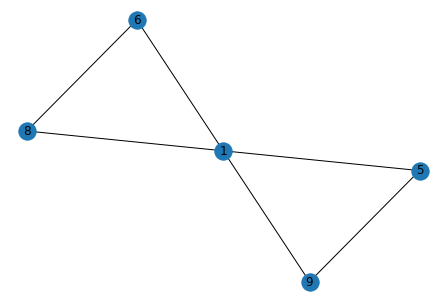

In [229]:
# Network setup. Each node is a box of marbles, each edge is a robotic arm.

num_nodes = 5
attachment_degree = 2

network = nx.barabasi_albert_graph(num_nodes, attachment_degree)

for node in network.nodes:
    network.nodes[node]["marbles"] = np.random.randint(1, 10)

nx.draw_kamada_kawai(network, labels=nx.get_node_attributes(network, "marbles"))

# Returns list of nodes in network
def get_nodes(ntwk):
    return [node for node in ntwk.nodes if ntwk.nodes[node]]

# Returns right-padded version of `vec` with length `length`
def pad(vec, length, zero_fill=True):
    if zero_fill:
        padded = np.zeros(length)
    else:
        padded = np.empty(length)
        padded[:] = np.nan
    
    for i in range(len(vec)):
        padded[i] = vec[i]

    return padded

def make2D(key, data, zero_fill=False):
    max_length = data[key].apply(len).max()
    new_key = "padded_" + key
    data[new_key] = data[key].apply(lambda vec: pad(vec, max_length, zero_fill))
    reshaped = np.array([val for val in data[new_key].values])

    return reshaped

In [230]:
# The system's initial state.

initial_state = { "network": network }

In [231]:
# Policy functions defining how much the state update functions should change the variables. (More modular than encoding agent behavior/logic in state update functions)

# For all edges in the graph (robotic arms managing a pair of boxes), one marble is moved from one box to the other on the edge accordignly with the marble disbalance.
def robot_network(params, step, sL, s):
    
    network = s["network"]
    box_deltas = {}

    for edge in network.edges:
        src_box = edge[0]
        dest_box = edge[1]
        box_deltas[edge] = np.sign(network.nodes[src_box]["marbles"] - network.nodes[dest_box]["marbles"])
    
    return { "box_deltas": box_deltas }

In [232]:
# The state transition functions ("mechanisms" in cadCAD) for the state variables.

def update_network(params, step, sL, s, _input):
    network = s["network"]
    box_deltas = _input["box_deltas"]

    for edge in network.edges:
        src_box = edge[0]
        dest_box = edge[1]
        delta = box_deltas[edge]
        if (network.nodes[src_box]["marbles"] >= delta) and (network.nodes[dest_box]["marbles"] >= -delta):
            network.nodes[src_box]["marbles"] -= delta
            network.nodes[dest_box]["marbles"] += delta

    return ("network", network)


In [233]:
# "Partial state update blocks", each dict in the list represents one execution block within which the state update functions run in parallel (blocks are run serially).

PSUBs = [{
    "policies": {   # Policies (define _input)
        "network_eq": robot_network
    },
    "variables": {  # State variable update functions
        "network": update_network
    }
}]

In [234]:
# Configuration parameters for the simulation.

params = {
    "T": range(25), # Number of timesteps
    "N": 1, # Number of Monte Carlo runs
    "M": {} # Ignored for now
}

In [235]:
# cadCAD Configuration object setup.

config = Configuration(sim_config=params, initial_state=initial_state, partial_state_update_blocks=PSUBs)

In [236]:
# Executing the simulation.

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config])

raw_result, tensor = executor.execute()


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: single_proc: [<cadCAD.configuration.Configuration object at 0x13226cac8>]
Configurations: [<cadCAD.configuration.Configuration object at 0x13226cac8>]


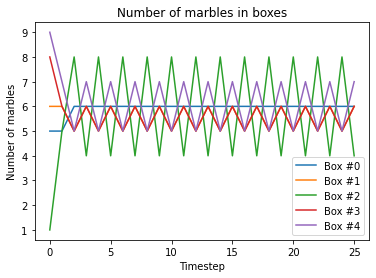

In [237]:
# Analyzing the simulation results.

df = pd.DataFrame(raw_result)
df["Marbles"] = df.network.apply(lambda ntwk: np.array([ntwk.nodes[node]["marbles"] for node in get_nodes(ntwk)]))

plt.plot(df.timestep, make2D("Marbles", df))
plt.title("Number of marbles in boxes")
plt.ylabel("Number of marbles")
plt.xlabel("Timestep")
plt.legend(["Box #"+str(node_idx) for node_idx in range(num_nodes)])